# BTK Datathon 2025 - Oturum Değer Tahmini

Bu notebook, **Unique()** takımının kullanıcı oturumlarının değerini tahmin etmek için geliştirdiği çözümü içermektedir.

## İçindekiler
1. **Veri Yükleme ve Ön İşleme**
2. **Veri Keşfi ve Analizi** 
3. **Veri Önişleme ve Hazırlık - Görselleştirme**
4. **Özellik Mühendisliği**
5. **Veri Setini Hazırlama**
5. **Model Eğitimi ve CV**
6. **Tahmin ve Sonuç Üretimi**


## 1. Veri Yükleme ve Ön İşleme

In [1]:
import polars as pl
import pandas as pd
from sklearnex import patch_sklearn
patch_sklearn()

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
import os
from pathlib import Path

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("crest")
warnings.filterwarnings('ignore')

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


DATA_PATH = "./raw_data/"

train = pl.read_csv(f"{DATA_PATH}/train.csv").sort(["user_session", "event_time"]).with_columns(pl.lit("train").alias("split"))
test = pl.read_csv(f"{DATA_PATH}/test.csv").sort(["user_session", "event_time"]).with_columns(pl.lit("test").alias("split"))
sub = pl.read_csv(f"{DATA_PATH}/sample_submission.csv")

Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


## 2. Veri Keşfi ve Analizi

**Analiz Edilen Konular:**
- Train ve test setlerindeki ürün dağılımları
- Ortak ve farklı ürünlerin belirlenmesi  
- Oturum değerlerinin analizi
- Kullanıcı ve oturum ilişkilerinin incelenmesi


In [2]:
# Get unique product_ids from train and test sets
train_products = set(train["product_id"].unique().to_list())
test_products = set(test["product_id"].unique().to_list())

# Find products only in train, only in test, and in both
products_only_in_train = train_products - test_products
products_only_in_test = test_products - train_products
products_in_both = train_products & test_products

print(f"Products only in train: {len(products_only_in_train)}")
print(f"Products only in test: {len(products_only_in_test)}")
print(f"Products in both: {len(products_in_both)}")
print(f"Total train products: {len(train_products)}")
print(f"Total test products: {len(test_products)}")


Products only in train: 11932
Products only in test: 2912
Products in both: 14538
Total train products: 26470
Total test products: 17450


Minimum oturum değerinin **5.38** olduğunu ve bu değerin oturumlar arası tekrarlandığını görebiliyoruz.

In [3]:
train.group_by("user_session").agg(
    pl.col("user_id").n_unique().alias("user_count"),
    pl.col("session_value").first()
    ).sort("session_value", descending=True)

user_session,user_count,session_value
str,u32,f64
"""SESSION_114996""",1,2328.66
"""SESSION_038767""",1,1946.93
"""SESSION_165310""",1,1749.42
"""SESSION_112650""",1,1691.01
"""SESSION_012254""",1,1137.33
…,…,…
"""SESSION_187888""",1,5.38
"""SESSION_188433""",1,5.38
"""SESSION_188692""",1,5.38


## 3. Veri Ön İşleme ve Hazırlık

- Train ve test verilerinin birleştirilmesi (`full_raw`)
- Zaman damgalarının datetime formatına çevrilmesi
- Kullanıcı-oturum eşleştirmelerinin oluşturulması
- Test ve holdout oturumlarının belirlenmesi
- Kategori ve kullanıcı ID'lerinden sayısal özelliklerin çıkarılması


In [4]:
session_target_df = train.unique(subset=["user_session", "session_value"]).select(["user_session", "session_value"]).sort(["user_session", "session_value"])

In [5]:
full_raw = pl.concat([train.drop("session_value"), test]).sort(["user_session", "event_time"])
full_raw = full_raw.with_columns(
    pl.col("event_time").str.to_datetime("%Y-%m-%d %H:%M:%S%z", strict=False)
)


session_user_df = full_raw.group_by("user_session", maintain_order=True).agg(
    pl.col("user_id").first().alias("user_id")
)

test_sessions = test["user_session"].unique().to_list()
train_sessions = train["user_session"].unique()
holdout_sessions = train_sessions.filter(train_sessions.is_in(test_sessions)).to_list()

### 3.1. Temel Veri Analizi
Oturumdaki aksiyonlar, zamansallık ve oturum değeri etiketi üzerine temel görselleştirmelerin yapılması. 

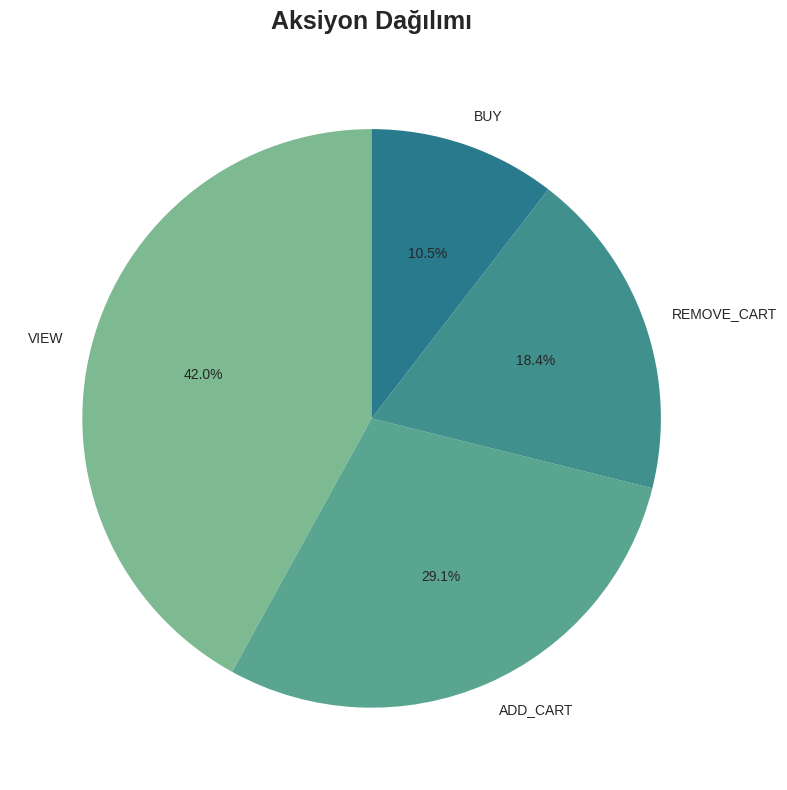

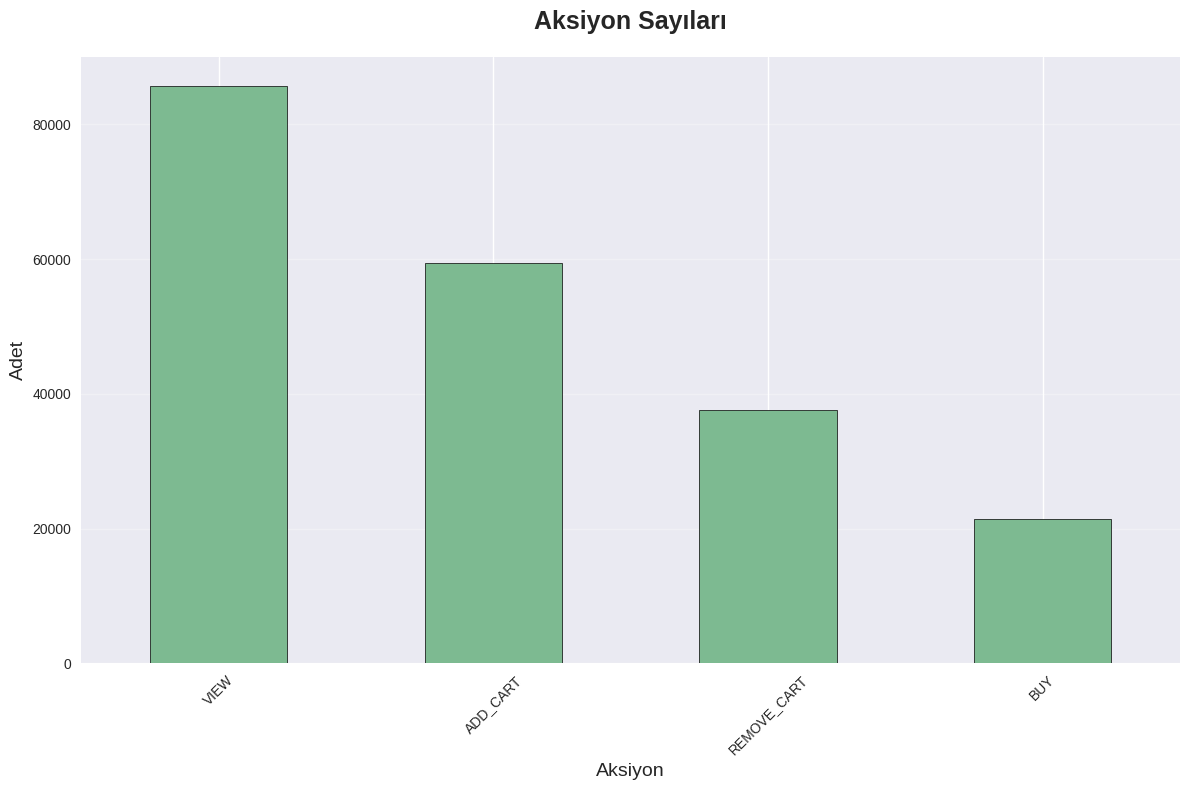

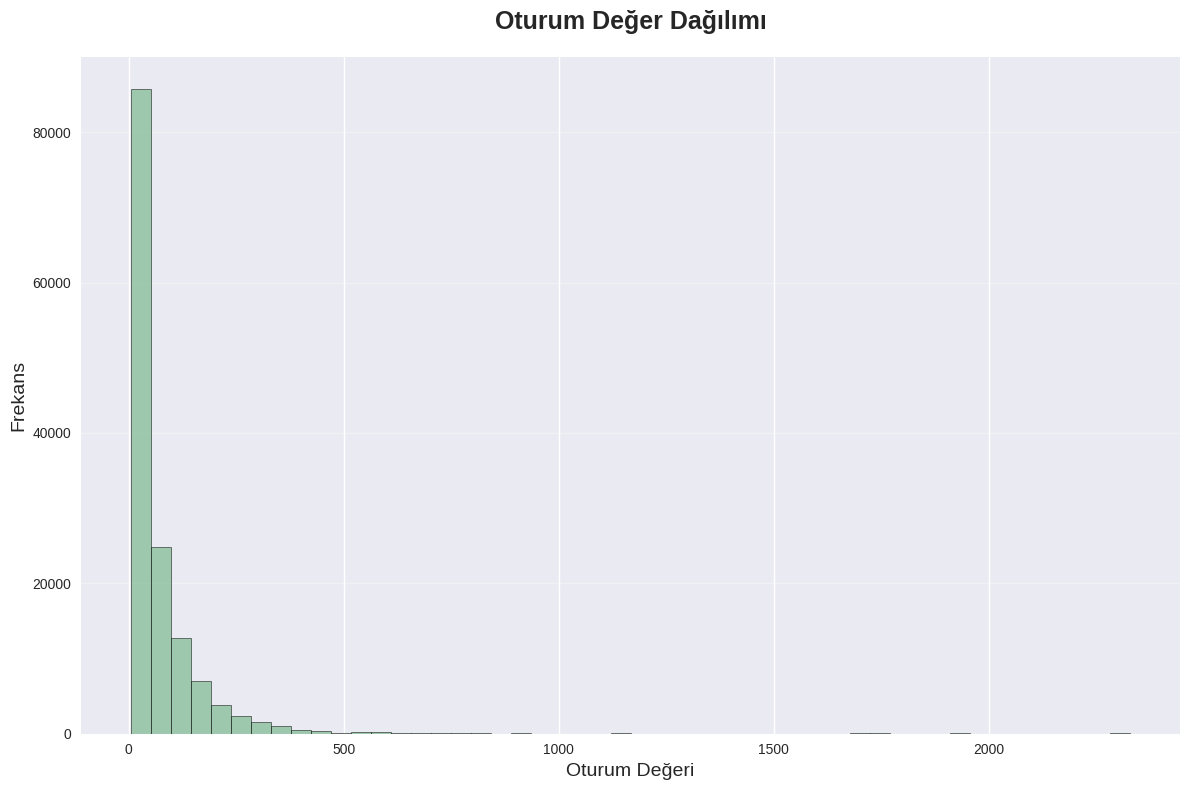

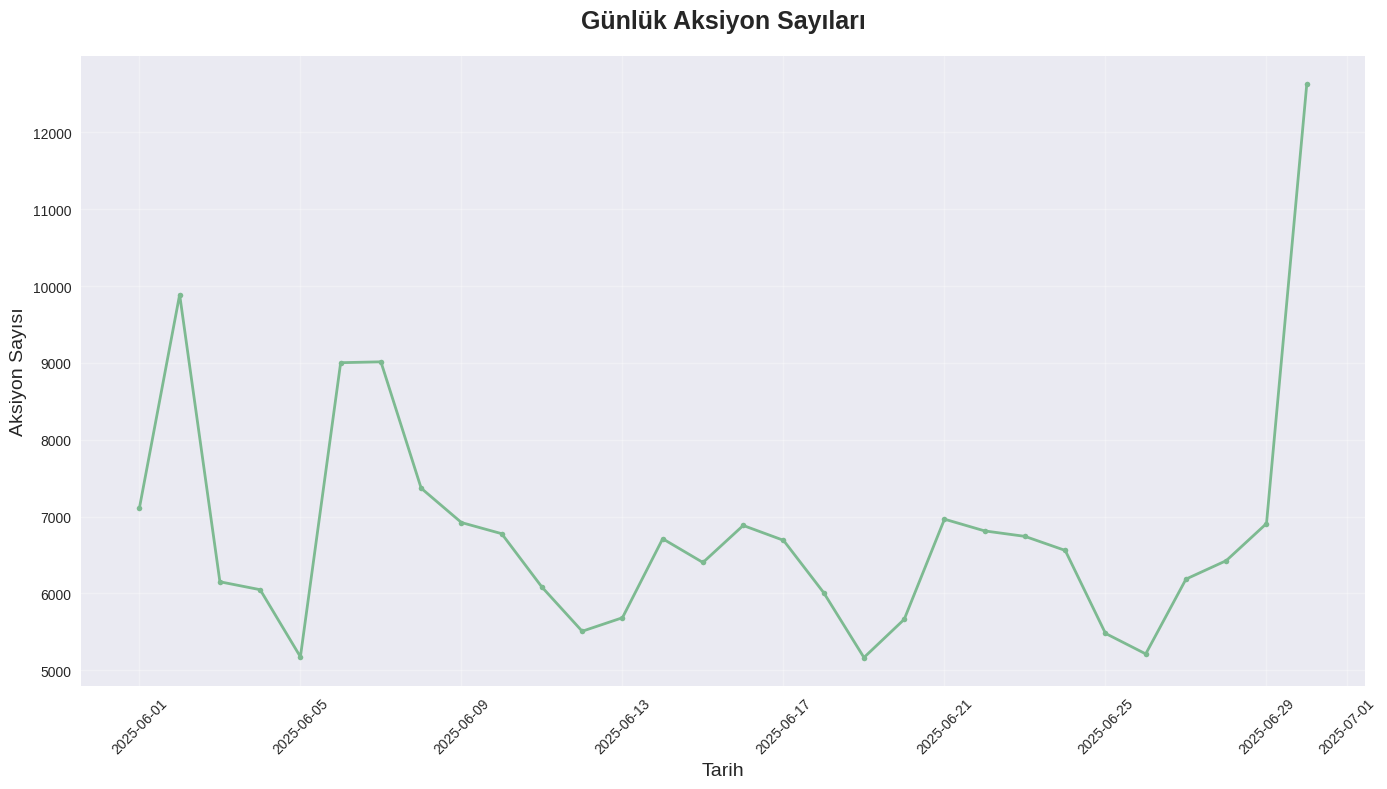

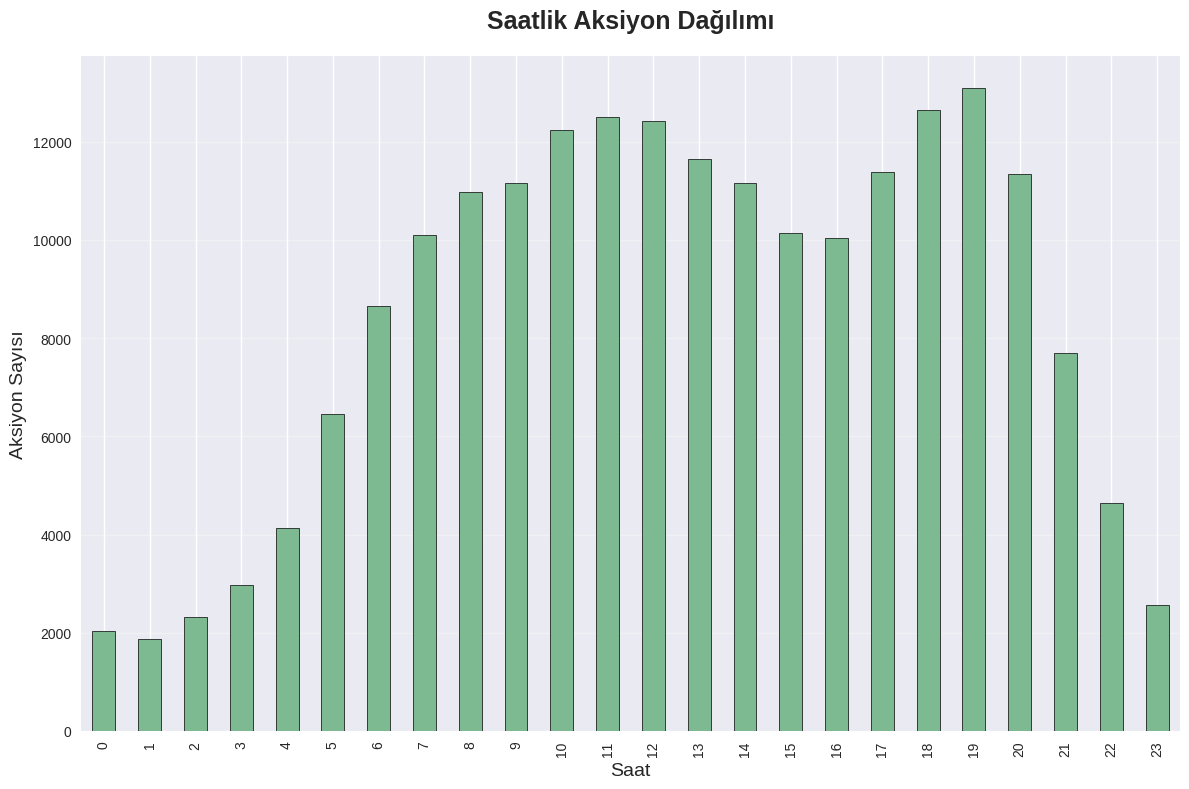

<Figure size 1400x800 with 0 Axes>

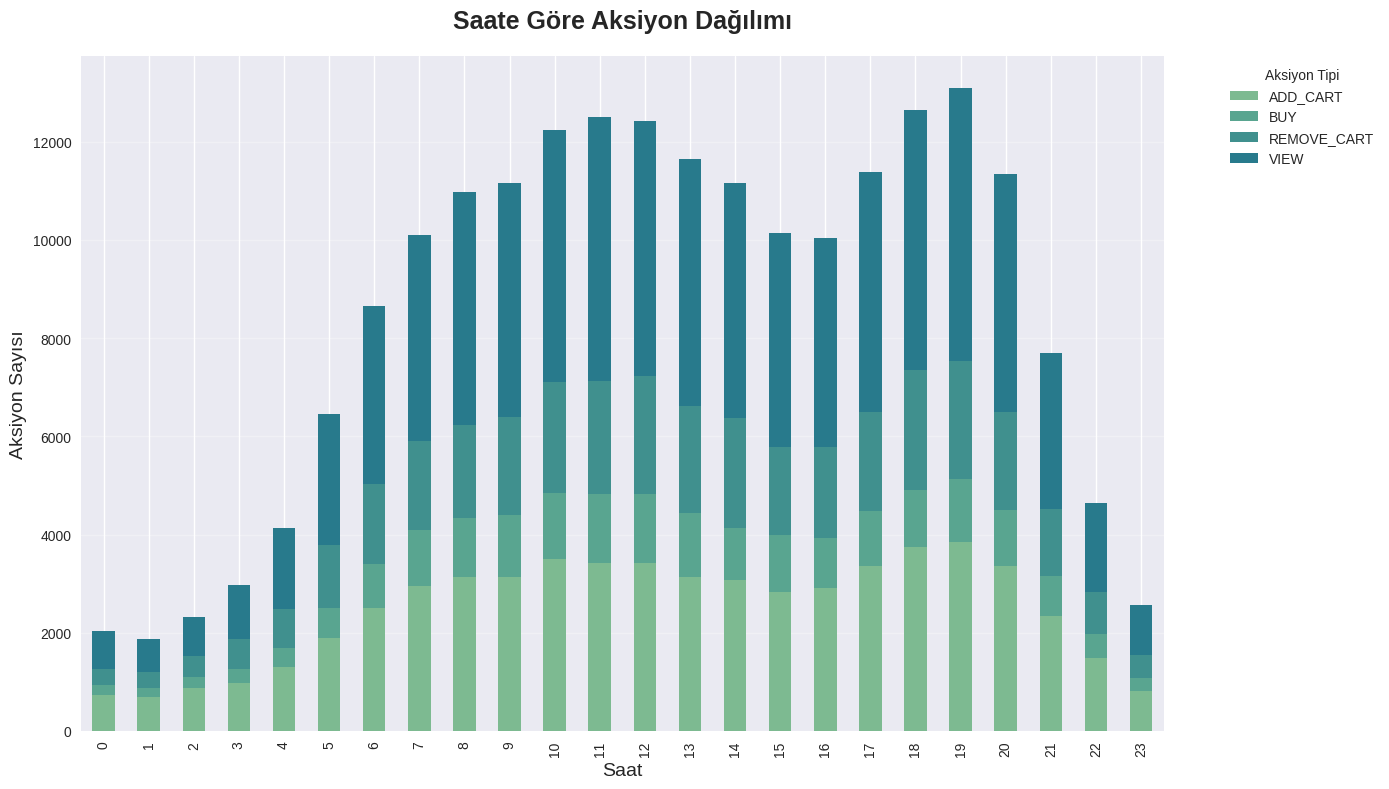

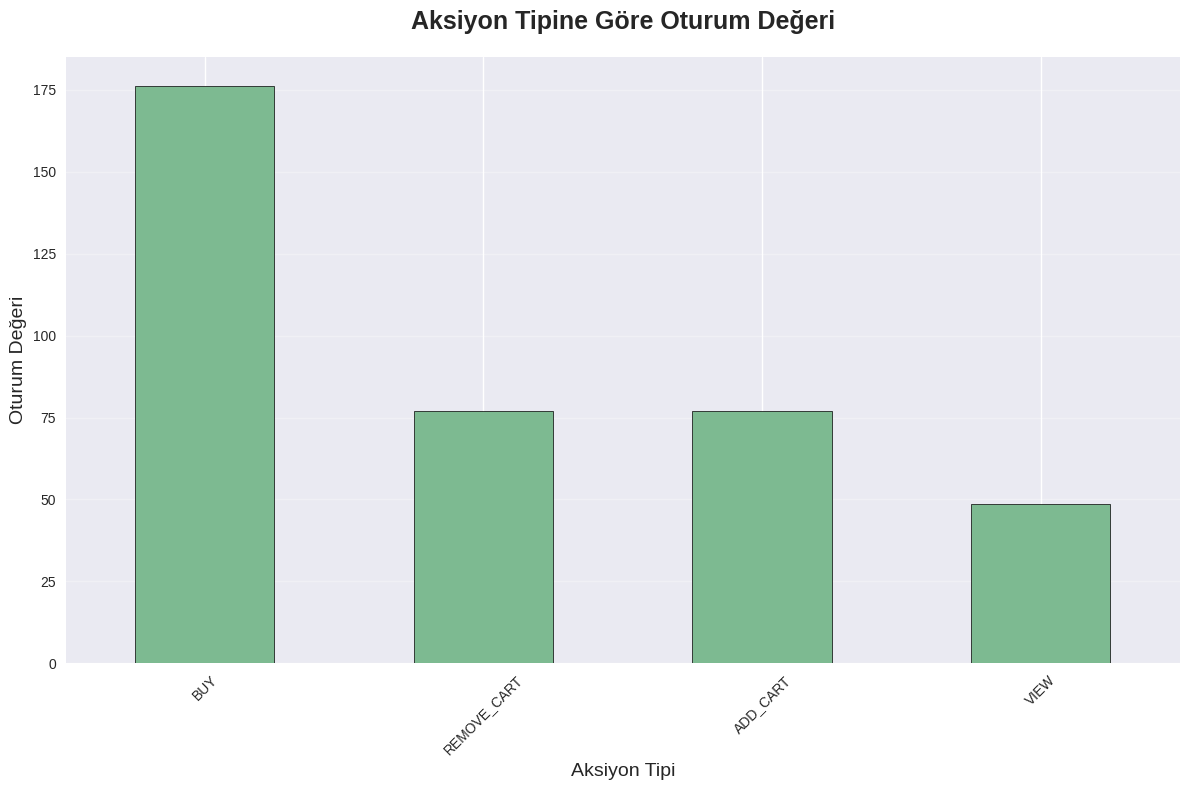

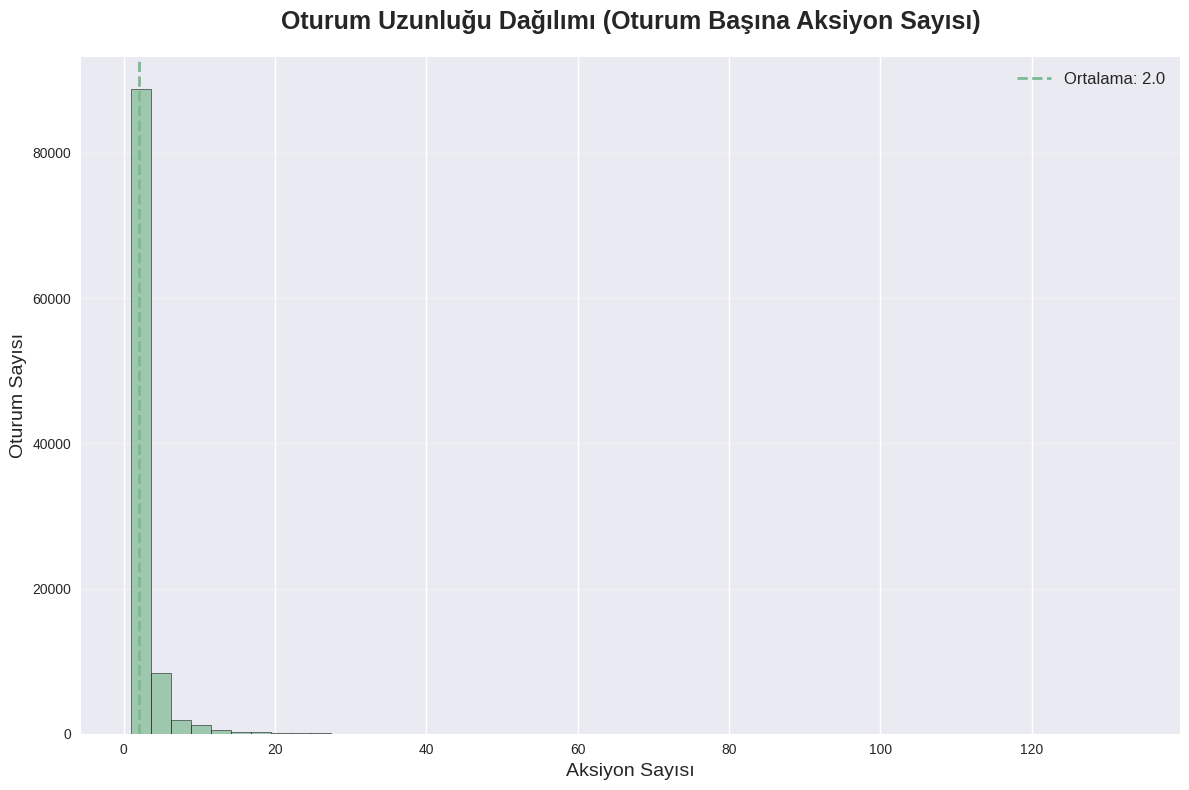

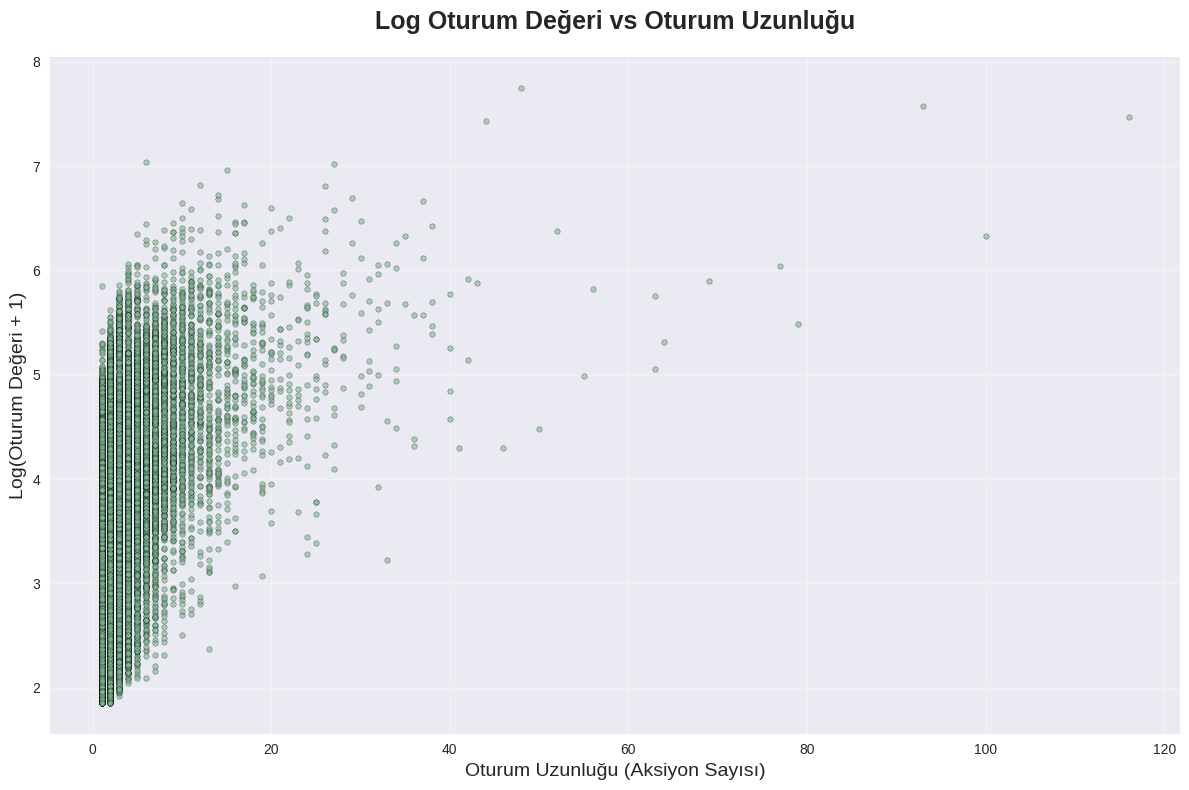

In [6]:
def plot_event_type_distribution(raw_train):
    """Create event type distribution pie chart."""
    plt.figure(figsize=(10, 8))
    event_counts = raw_train['event_type'].value_counts()
    plt.pie(event_counts.values, labels=event_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title('Aksiyon Dağılımı', fontsize=18, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()


def plot_event_type_counts(raw_train):
    plt.figure(figsize=(12, 8))
    event_counts = raw_train['event_type'].value_counts()
    event_counts.plot(kind='bar', edgecolor='black', linewidth=0.5)
    plt.title('Aksiyon Sayıları', fontsize=18, fontweight='bold', pad=20)
    plt.xlabel('Aksiyon', fontsize=14)
    plt.ylabel('Adet', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_session_value_distribution(raw_train):
    plt.figure(figsize=(12, 8))
    plt.hist(raw_train['session_value'], bins=50, alpha=0.7, edgecolor='black', linewidth=0.5)
    plt.title('Oturum Değer Dağılımı', fontsize=18, fontweight='bold', pad=20)
    plt.xlabel('Oturum Değeri', fontsize=14)
    plt.ylabel('Frekans', fontsize=14)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_daily_events(raw_train):
    plt.figure(figsize=(14, 8))
    daily_events = raw_train.groupby(raw_train['event_time'].dt.date).size()
    daily_events.plot(linewidth=2, marker='o', markersize=4)
    plt.title('Günlük Aksiyon Sayıları', fontsize=18, fontweight='bold', pad=20)
    plt.xlabel('Tarih', fontsize=14)
    plt.ylabel('Aksiyon Sayısı', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def plot_hourly_events(raw_train):
    plt.figure(figsize=(12, 8))
    hourly_events = raw_train.groupby(raw_train['event_time'].dt.hour).size()
    hourly_events.plot(kind='bar', edgecolor='black', linewidth=0.5)
    plt.title('Saatlik Aksiyon Dağılımı', fontsize=18, fontweight='bold', pad=20)
    plt.xlabel('Saat', fontsize=14)
    plt.ylabel('Aksiyon Sayısı', fontsize=14)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_events_by_hour(raw_train):
    plt.figure(figsize=(14, 8))
    event_hour = pd.crosstab(raw_train['event_time'].dt.hour, raw_train['event_type'])
    event_hour.plot(kind='bar', stacked=True, figsize=(14, 8))
    plt.title('Saate Göre Aksiyon Dağılımı', fontsize=18, fontweight='bold', pad=20)
    plt.xlabel('Saat', fontsize=14)
    plt.ylabel('Aksiyon Sayısı', fontsize=14)
    plt.legend(title='Aksiyon Tipi', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_session_value_by_event(raw_train):
    plt.figure(figsize=(12, 8))
    session_value_by_event = raw_train.groupby('event_type')['session_value'].mean().sort_values(ascending=False)
    session_value_by_event.plot(kind='bar', edgecolor='black', linewidth=0.5)
    plt.title('Aksiyon Tipine Göre Oturum Değeri', fontsize=18, fontweight='bold', pad=20)
    plt.xlabel('Aksiyon Tipi', fontsize=14)
    plt.ylabel('Oturum Değeri', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_session_length_distribution(raw_train):
    plt.figure(figsize=(12, 8))
    session_lengths = raw_train.groupby('user_session').size()
    plt.hist(session_lengths, bins=50, alpha=0.7, edgecolor='black', linewidth=0.5)
    plt.axvline(session_lengths.mean(), linestyle='--', linewidth=2,
               label=f'Ortalama: {session_lengths.mean():.1f}')
    plt.title('Oturum Uzunluğu Dağılımı (Oturum Başına Aksiyon Sayısı)', fontsize=18, fontweight='bold', pad=20)
    plt.xlabel('Aksiyon Sayısı', fontsize=14)
    plt.ylabel('Oturum Sayısı', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_log_session_value_vs_length(raw_train):
    plt.figure(figsize=(12, 8))
    session_stats = raw_train.groupby('user_session').agg({
        'session_value': 'first',
        'event_type': 'count'
    }).rename(columns={'event_type': 'event_count'})
    
    log_session_value = np.log1p(session_stats['session_value'])
    
    plt.scatter(session_stats['event_count'], log_session_value, 
               alpha=0.6, s=15, edgecolors='black', linewidth=0.3)
    plt.title('Log Oturum Değeri vs Oturum Uzunluğu', fontsize=18, fontweight='bold', pad=20)
    plt.xlabel('Oturum Uzunluğu (Aksiyon Sayısı)', fontsize=14)
    plt.ylabel('Log(Oturum Değeri + 1)', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


plot_event_type_distribution(full_raw.to_pandas())
plot_event_type_counts(full_raw.to_pandas())
plot_session_value_distribution(train.to_pandas())
plot_daily_events(full_raw.to_pandas())
plot_hourly_events(full_raw.to_pandas())
plot_events_by_hour(full_raw.to_pandas())
plot_session_value_by_event(train.to_pandas())
plot_session_length_distribution(full_raw.to_pandas())
plot_log_session_value_vs_length(train.to_pandas())

## 4. Özellik Mühendisliği Fonksiyonları

### 4.1 Kategori Encoding

- Leave-one-out yaklaşımı ile veri sızıntısını önler
- Kategori bazında ortalama oturum değer istatistikleri hesaplar
- Event türlerine göre ayrıştırılmış özellik çıkarımı yapar

In [7]:
def calculate_value_features_optimized(train_df):
    """
    Pre-calculate category value statistics for all sessions efficiently.
    Uses leave-one-out approach to prevent data leakage.
    Split by event_type for more granular features.
    
    Args:
        train_df: Training data with session_value
        
    Returns:
        DataFrame with session-level value features
    """
    # Pre-calculate global statistics (session-wise aggregation first)
    session_category_values = train_df.group_by(["user_session", "category_id", "event_type"]).agg([
        pl.col("session_value").first().alias("session_value")
    ])
    
    global_category_stats = session_category_values.group_by(["user_session", "category_id", "event_type"]).agg([
        pl.col("session_value").sum().alias("category_total_value"),
        pl.col("session_value").count().alias("category_total_count")
    ]).group_by(["category_id", "event_type"]).agg([
        pl.col("category_total_value").sum(),
        pl.col("category_total_count").sum()
    ])
    
    # Join global stats to session data
    session_enriched = (
        train_df
        .join(global_category_stats, on=["category_id", "event_type"], how="left")
    )
    
    # Calculate leave-one-out statistics efficiently
    session_value_features = session_enriched.with_columns([
        # Category leave-one-out mean (exclude current session's contribution)
        ((pl.col("category_total_value") - pl.col("session_value")) / 
         pl.max_horizontal(pl.col("category_total_count") - 1, 1)).alias("category_mean_value_loo"),
        
        # Count features (excluding current session)
        (pl.col("category_total_count") - 1).alias("category_value_count_loo")
    ]).select([
        "user_session", "category_id", "event_type", "session_value",
        "category_mean_value_loo", 
        #"category_value_count_loo"
    ])
    
    return session_value_features

# Calculate frequencies from full_raw data (these don't contain target values so no leakage)
category_freq = full_raw.group_by("category_id").agg([
    pl.col("category_id").count().alias("category_frequency")
])

# Pre-calculate value features for all sessions at once
session_value_features = calculate_value_features_optimized(train)
session_value_features.head()

user_session,category_id,event_type,session_value,category_mean_value_loo
str,str,str,f64,f64
"""SESSION_000000""","""CAT_00144""","""ADD_CART""",355.8,89.577562
"""SESSION_000000""","""CAT_00114""","""REMOVE_CART""",355.8,33.532143
"""SESSION_000000""","""CAT_00242""","""ADD_CART""",355.8,42.659385
"""SESSION_000000""","""CAT_00266""","""ADD_CART""",355.8,70.756034
"""SESSION_000000""","""CAT_00268""","""ADD_CART""",355.8,58.241233


### 4.2 Session İçi Özellik Çıkarımı

- **Oturum İstatistikleri:** Event sayıları, süre, çeşitlilik metrikleri
- **Davranışsal Özellikler:** Dönüşüm oranları, sepet davranışları
- **Temporal Özellikler:** Saat dağılımları, yoğunluk metrikleri
- **Sepet Analizi:** Çoklu ürün sepetleri, kategori çeşitliliği
- **Akış Verimliliği:** Kullanıcı yolculuğu ve davranış skorları

Analizlerimizde oturum içindeki ürün ekleme ve alım yönündeki aksiyonların oturum değeri ile yüksek korelasyona sahip olduğunu gördük. Bunların korelasyon gücüne göre sıralı ağırlıklandırılmış bir toplam aksiyon skoru çıkardığımızda ise bunun modelimizi iyileştirdiğini farkettik.
- BUY (4 puan): En değerli eylem, gerçek gelir getiren davranış
- ADD_CART (2 puan): Orta değerli eylem, satın alma niyetini gösterir
- VIEW (1 puan): Temel eylem, ilgi göstergesi ancak düşük değerli

In [8]:
import polars as pl

def create_features(df: pl.DataFrame) -> pl.DataFrame:
    """
    Basit feature engineering - tek DataFrame alıp feature'lı halini döner
    
    Args:
        df: Raw event data (user_session, event_time, event_type, user_id, etc.)
        
    Returns:
        DataFrame with session-level features
    """
    
    # Join product and category frequencies
    df_enriched = (
        df
        .join(category_freq, on="category_id", how="left")
    )
    
    # Session bazında feature'lar
    features = df_enriched.group_by(["user_session"], maintain_order=True).agg(
        # Event sayıları
        pl.col("event_time").count().alias("session_event_count"),
        pl.col("event_time").first().alias("start_time"),
        (pl.col("event_type") == "VIEW").sum().alias("session_view_count"),
        (pl.col("event_type") == "ADD_CART").sum().alias("session_add_cart_count"),
        (pl.col("event_type") == "REMOVE_CART").sum().alias("session_remove_cart_count"),
        (pl.col("event_type") == "BUY").sum().alias("session_buy_count"),
        
        # Session süresi (saniye cinsinden)
        ((pl.col("event_time").max() - pl.col("event_time").min()).dt.total_seconds()).alias("session_duration_seconds"),
        
        # İlk ve son event tipleri
        pl.col("event_type").first().alias("first_event"),
        pl.col("event_type").last().alias("last_event"),
        
        # Event tipi çeşitliliği
        pl.col("event_type").n_unique().alias("unique_event_types"),
        
        # Product feature'ları
        pl.col("product_id").n_unique().alias("unique_products"),
        pl.col("product_id").count().alias("total_product_interactions"),
        
        # Category feature'ları
        pl.col("category_id").n_unique().alias("unique_categories"),
        pl.col("category_id").count().alias("total_category_interactions"),
        
    )
    
    # Join session value features (excluding session_value to prevent leakage)
    session_value_features_no_leak = session_value_features.select([
        "user_session", "category_id", "event_type",
        "category_mean_value_loo", 
    ])
    
    # Aggregate session value features by session and event_type
    session_value_agg = session_value_features_no_leak.group_by(["user_session"], maintain_order=True).agg([

        # Category mean value aggregations by event_type
        pl.col("category_mean_value_loo").filter(pl.col("event_type") == "VIEW").sum().alias("sum_category_mean_value_loo_view"),    
        pl.col("category_mean_value_loo").filter(pl.col("event_type") == "ADD_CART").sum().alias("sum_category_mean_value_loo_add_cart"),
        pl.col("category_mean_value_loo").filter(pl.col("event_type") == "REMOVE_CART").sum().alias("sum_category_mean_value_loo_remove_cart"),
        pl.col("category_mean_value_loo").filter(pl.col("event_type") == "BUY").sum().alias("sum_category_mean_value_loo_buy"),
    ])
    
    # Net cart calculation per product within session, then summed
    net_cart_features = df_enriched.group_by(["user_session", "product_id"], maintain_order=True).agg([
        (pl.col("event_type") == "ADD_CART").sum().alias("product_add_cart"),
        (pl.col("event_type") == "REMOVE_CART").sum().alias("product_remove_cart"),
    ]).with_columns([
        (pl.col("product_add_cart") - pl.col("product_remove_cart")).alias("product_net_cart")
    ]).group_by("user_session").agg([
        pl.col("product_net_cart").sum().alias("session_net_cart_count"),
        (pl.col("product_net_cart") > 0).sum().alias("session_net_cart_unique_products"),
    ])
    
    # Multi-product basket features (same timestamp BUY events)
    basket_features = df_enriched.filter(pl.col("event_type") == "BUY").group_by(["user_session", "event_time"], maintain_order=True).agg([
        pl.col("product_id").count().alias("products_in_basket"),
        pl.col("category_id").n_unique().alias("categories_in_basket"),
    ]).group_by("user_session").agg([
        # Basket transaction features
        pl.col("products_in_basket").count().alias("basket_transaction_count"),
        pl.col("products_in_basket").max().alias("max_basket_size"),
        pl.col("products_in_basket").mean().alias("avg_basket_size"),
        pl.col("products_in_basket").sum().alias("total_basket_products"),
        
        # Multi-product basket indicators
        (pl.col("products_in_basket") > 1).sum().alias("multi_product_baskets"),
        (pl.col("products_in_basket") == 1).sum().alias("single_product_baskets"),
        
        # Category diversity in baskets
        pl.col("categories_in_basket").max().alias("max_categories_per_basket"),
        pl.col("categories_in_basket").mean().alias("avg_categories_per_basket"),
        
        # Basket complexity score
        (pl.col("products_in_basket") * pl.col("categories_in_basket")).max().alias("max_basket_complexity"),
        (pl.col("products_in_basket") * pl.col("categories_in_basket")).mean().alias("avg_basket_complexity"),
    ])
    
    # Ratio feature'ları ayrı hesapla
    features = features.with_columns([
        # Product ratios
        (pl.col("total_product_interactions") / pl.col("session_event_count")).alias("product_interaction_rate"),
        (pl.col("unique_products") / pl.col("session_event_count")).alias("product_diversity"),
        
        # Category ratios
        (pl.col("total_category_interactions") / pl.col("session_event_count")).alias("category_interaction_rate"),
        (pl.col("unique_categories") / pl.col("session_event_count")).alias("category_diversity"),
        (pl.col("unique_categories") / (pl.col("unique_products") + 1e-8)).alias("category_product_ratio"),
        
        # Conversion Metrics
        (pl.col("session_buy_count") / (pl.col("session_add_cart_count") + 1e-8)).alias("cart_to_purchase_rate"),
        (pl.col("session_add_cart_count") / (pl.col("session_view_count") + 1e-8)).alias("view_to_cart_rate"),
        (pl.col("session_buy_count") / pl.col("session_event_count")).alias("overall_conversion_rate"),
        
        # Cart Behavior
        (pl.col("session_add_cart_count") - pl.col("session_buy_count")).alias("cart_abandonment_count"),
        (pl.col("session_remove_cart_count") / (pl.col("session_add_cart_count") + 1e-8)).alias("cart_removal_rate"),
        
        # User Engagement
        ((pl.col("session_buy_count") + pl.col("session_add_cart_count")) / pl.col("session_event_count")).alias("goal_oriented_ratio"),
        (pl.col("session_view_count") / pl.col("session_event_count")).alias("browsing_ratio"),
        
        # Product/Category Patterns
        (pl.col("unique_products") / (pl.col("unique_categories") + 1e-8)).alias("products_per_category"),
        (pl.col("unique_categories") / (pl.col("unique_products") + 1e-8)).alias("categories_per_product"),
        
        # Last event indicator
        (pl.col("last_event") == "BUY").alias("last_event_is_purchase"),

        
        # Session positive event score
        (pl.col("session_buy_count")*4 + pl.col("session_add_cart_count")*2 + pl.col("session_view_count")*1).alias("session_positive_event_score"),

    ])
    
    
    # Temporal features
    temporal_features = df_enriched.group_by(["user_session"], maintain_order=True).agg([
        pl.col("event_time").dt.hour().first().alias("session_start_hour"),
        pl.col("event_time").dt.weekday().first().alias("session_start_weekday"),
    ])

    # Session intensity features
    intensity_features = df_enriched.group_by(["user_session"], maintain_order=True).agg([
        (pl.col("event_time").count() / ((pl.col("event_time").max() - pl.col("event_time").min()).dt.total_seconds() / 60 + 1e-8)).alias("events_per_minute"),
        (pl.col("event_time").count() / ((pl.col("event_time").max() - pl.col("event_time").min()).dt.total_seconds() / 3600 + 1e-8)).alias("events_per_hour"),
    ])
    
    # Additional simple features
    additional_features = df_enriched.group_by(["user_session"], maintain_order=True).agg([
        # Session duration in minutes
        ((pl.col("event_time").max() - pl.col("event_time").min()).dt.total_seconds() / 60).alias("session_duration_minutes"),
    ])
    
    # Event transition patterns ve flow efficiency
    transition_features = df_enriched.group_by(["user_session"], maintain_order=True).agg([
        # Flow efficiency features
        pl.when(pl.col("event_type").first() == "VIEW").then(pl.lit(1))
        .when(pl.col("event_type").first() == "ADD_CART").then(pl.lit(2))
        .when(pl.col("event_type").first() == "BUY").then(pl.lit(3))
        .otherwise(pl.lit(0)).alias("session_start_efficiency"),
        
        pl.when(pl.col("event_type").last() == "BUY").then(pl.lit(3))
        .when(pl.col("event_type").last() == "ADD_CART").then(pl.lit(2))
        .when(pl.col("event_type").last() == "VIEW").then(pl.lit(1))
        .otherwise(pl.lit(0)).alias("session_end_efficiency"),
        
        # Session flow score (higher = more efficient)
        pl.when((pl.col("event_type").first() == "VIEW") & (pl.col("event_type").last() == "BUY")).then(pl.lit(3))
        .when((pl.col("event_type").first() == "VIEW") & (pl.col("event_type").last() == "ADD_CART")).then(pl.lit(2))
        .when((pl.col("event_type").first() == "ADD_CART") & (pl.col("event_type").last() == "BUY")).then(pl.lit(2))
        .when((pl.col("event_type").first() == "VIEW") & (pl.col("event_type").last() == "VIEW")).then(pl.lit(1))
        .otherwise(pl.lit(0)).alias("session_flow_score"),
        
        # Session depth (how deep user goes in funnel)
        pl.when((pl.col("event_type") == "BUY").sum() > 0).then(pl.lit(3))
        .when((pl.col("event_type") == "ADD_CART").sum() > 0).then(pl.lit(2))
        .when((pl.col("event_type") == "VIEW").sum() > 0).then(pl.lit(1))
        .otherwise(pl.lit(0)).alias("session_depth"),
    ])
    
    # Tüm feature'ları birleştir
    final_features = (
        features
        .join(session_value_agg, on=["user_session"], how="left")
        .join(net_cart_features, on=["user_session"], how="left")
        .join(basket_features, on=["user_session"], how="left")
        .join(temporal_features, on=["user_session"], how="left")
        .join(intensity_features, on=["user_session"], how="left")
        .join(additional_features, on=["user_session"], how="left")
        .join(transition_features, on=["user_session"], how="left")
    )
    
    # Add value-based features after joining session value aggregations
    final_features = final_features.with_columns([

        # Category value based features by event_type
        (pl.col("sum_category_mean_value_loo_view") / (pl.col("session_view_count") + 1e-8)).alias("weighted_category_value_loo_view"),
        (pl.col("sum_category_mean_value_loo_add_cart") / (pl.col("session_add_cart_count") + 1e-8)).alias("weighted_category_value_loo_add_cart"),
        (pl.col("sum_category_mean_value_loo_remove_cart") / (pl.col("session_remove_cart_count") + 1e-8)).alias("weighted_category_value_loo_remove_cart"),
        (pl.col("sum_category_mean_value_loo_buy") / (pl.col("session_buy_count") + 1e-8)).alias("weighted_category_value_loo_buy"),
        
        # Basket behavior ratios
        (pl.col("multi_product_baskets") / (pl.col("basket_transaction_count") + 1e-8)).alias("multi_basket_ratio"),
        (pl.col("single_product_baskets") / (pl.col("basket_transaction_count") + 1e-8)).alias("single_basket_ratio"),
        
        # Basket efficiency features
        (pl.col("total_basket_products") / (pl.col("basket_transaction_count") + 1e-8)).alias("products_per_transaction"),
        (pl.col("max_basket_size") / (pl.col("unique_products") + 1e-8)).alias("max_basket_coverage"),
        
        # Shopping pattern indicators
        pl.when(pl.col("multi_product_baskets").fill_null(0) > 0).then(pl.lit(1)).otherwise(pl.lit(0)).alias("has_multi_product_baskets"),
        pl.when(pl.col("max_basket_size").fill_null(0) >= 3).then(pl.lit(1)).otherwise(pl.lit(0)).alias("has_large_baskets"),
    ])
    
    return final_features

In [9]:
agg_df = create_features(full_raw)

### 4.3 Geçmiş ve Genel Davranış Özellikleri

- **Kümülatif Metrikler:** Toplam event, görüntüleme, satın alma sayıları
- **Geçmiş Ortalamalar:** Oturum uzunluğu, süre, aktivite ortalamaları  
- **Dönüşüm Oranları:** Görüntülemeden satın almaya, sepete ekleme oranları
- **Davranış Tutarlılığı:** Mevcut oturumun geçmiş ortalamalara oranı
- **Kalite Metrikleri:** Oturum akışı, derinlik, verimlilik skorları
- **Sepet Geçmişi:** Çoklu ürün sepeti alışkanlıkları

Veriseti sentetik olduğu için kullanıcı alışkanlıklarının durağan ve ekstrapole edilebilir olduğunu gördük. Bu yüzden ürettiğimiz bazı öznitelikler look-ahead leak içeriyor.

In [10]:
historical_feat_df = (
    agg_df
    .join(session_user_df, on="user_session", how="left")
    .join(session_target_df, on="user_session", how="left")
    .sort("user_id", "start_time")
    .with_columns([
        pl.col("session_event_count").cum_sum().over("user_id").alias("cumsum_session_event_count"),
        pl.col("session_view_count").cum_sum().over("user_id").alias("cumsum_session_view_count"),
        pl.col("session_add_cart_count").cum_sum().over("user_id").alias("cumsum_session_add_cart_count"),
        pl.col("session_remove_cart_count").cum_sum().over("user_id").alias("cumsum_session_remove_cart_count"),
        pl.col("session_buy_count").cum_sum().over("user_id").alias("cumsum_session_buy_count"),

        pl.col("session_positive_event_score").sum().over("user_id").alias("sum_session_positive_event_score"),

        # Historical means
        pl.col("session_event_count").mean().over("user_id").alias("historical_mean_session_event_count"),
        pl.col("session_view_count").mean().over("user_id").alias("historical_mean_session_view_count"),
        pl.col("session_add_cart_count").mean().over("user_id").alias("historical_mean_session_add_cart_count"),
        pl.col("session_remove_cart_count").mean().over("user_id").alias("historical_mean_session_remove_cart_count"),
        # pl.col("session_net_cart_count").mean().over("user_id").alias("historical_mean_session_net_cart_count"),
        pl.col("session_buy_count").mean().over("user_id").alias("historical_mean_session_buy_count"),

        # Historical conversion rates (CR) and click-through rates (CTR)
        (pl.col("session_buy_count").cum_sum().over("user_id") / pl.col("session_view_count").cum_sum().over("user_id")).alias("historical_view_to_buy_cr"),
        (pl.col("session_add_cart_count").cum_sum().over("user_id") / pl.col("session_view_count").cum_sum().over("user_id")).alias("historical_view_to_cart_ctr"),
        (pl.col("session_buy_count").cum_sum().over("user_id") / pl.col("session_add_cart_count").cum_sum().over("user_id")).alias("historical_cart_to_buy_cr"),
        (pl.col("session_buy_count").cum_sum().over("user_id") / pl.col("session_event_count").cum_sum().over("user_id")).alias("historical_buy_to_total_rate"),
        (pl.col("session_remove_cart_count").cum_sum().over("user_id") / pl.col("session_add_cart_count").cum_sum().over("user_id")).alias("historical_cart_abandonment_rate"),
        
        # Historical session counts
        pl.int_range(pl.len()).over("user_id").alias("historical_session_count") + 1,
        
        # Session Momentum Features - Above average indicators
        pl.when(pl.col("session_event_count") > pl.col("session_event_count").mean().over("user_id")).then(pl.lit(1)).otherwise(pl.lit(0)).alias("above_avg_session_length"),
        pl.when(pl.col("session_duration_seconds") > pl.col("session_duration_seconds").mean().over("user_id")).then(pl.lit(1)).otherwise(pl.lit(0)).alias("above_avg_session_duration"),
        pl.when(pl.col("unique_products") > pl.col("unique_products").mean().over("user_id")).then(pl.lit(1)).otherwise(pl.lit(0)).alias("above_avg_product_diversity"),
        pl.when(pl.col("unique_categories") > pl.col("unique_categories").mean().over("user_id")).then(pl.lit(1)).otherwise(pl.lit(0)).alias("above_avg_category_diversity"),
        
        # User Behavior Consistency - Ratios to historical means
        (pl.col("session_event_count") / pl.col("session_event_count").mean().over("user_id")).alias("session_length_ratio"),
        (pl.col("session_duration_seconds") / pl.col("session_duration_seconds").mean().over("user_id")).alias("session_duration_ratio"),
        (pl.col("unique_products") / pl.col("unique_products").mean().over("user_id")).alias("product_diversity_ratio"),
        (pl.col("unique_categories") / pl.col("unique_categories").mean().over("user_id")).alias("category_diversity_ratio"),
        
        # Historical Session Quality Metrics
        pl.col("session_flow_score").mean().over("user_id").alias("historical_mean_session_flow"),
        pl.col("session_depth").mean().over("user_id").alias("historical_mean_session_depth"),
        pl.col("session_start_efficiency").mean().over("user_id").alias("historical_mean_session_start_efficiency"),
        pl.col("session_end_efficiency").mean().over("user_id").alias("historical_mean_session_end_efficiency"),
        
        # Historical Conversion Efficiency
        (pl.col("session_add_cart_count").cum_sum().over("user_id") / pl.col("session_event_count").cum_sum().over("user_id")).alias("historical_cart_engagement_rate"),
        (pl.col("session_add_cart_count").sum() / pl.col("session_event_count").sum()).alias("historical_mean_cart_engagement_rate"),
    
        pl.col("has_multi_product_baskets").mean().over("user_id").alias("historical_mean_has_multi_product_baskets"),
        pl.col("has_large_baskets").mean().over("user_id").alias("historical_mean_has_large_baskets"),
        pl.col("has_multi_product_baskets").sum().over("user_id").alias("sum_has_multi_product_baskets"),
        pl.col("has_large_baskets").sum().over("user_id").alias("sum_has_large_baskets"),
        pl.col("max_basket_coverage").sum().over("user_id").alias("sum_max_basket_coverage"),

        # Historical Trend Indicators
        pl.when(pl.col("session_event_count") > pl.col("session_event_count").shift(1).over("user_id")).then(pl.lit(1))
        .when(pl.col("session_event_count") < pl.col("session_event_count").shift(1).over("user_id")).then(pl.lit(-1))
        .otherwise(pl.lit(0)).alias("session_length_trend"),
        
        pl.when(pl.col("session_duration_seconds") > pl.col("session_duration_seconds").shift(1).over("user_id")).then(pl.lit(1))
        .when(pl.col("session_duration_seconds") < pl.col("session_duration_seconds").shift(1).over("user_id")).then(pl.lit(-1))
        .otherwise(pl.lit(0)).alias("session_duration_trend"),
        
    ])
    .select([
        "user_session",
        "user_id",
        "sum_session_positive_event_score",

        # Historical means
        "historical_mean_session_event_count", "historical_mean_session_view_count",
        "historical_mean_session_add_cart_count", "historical_mean_session_remove_cart_count",
        "historical_mean_session_buy_count",
        
        # Historical conversion rates
        "historical_view_to_buy_cr", "historical_view_to_cart_ctr",
        "historical_cart_to_buy_cr", "historical_buy_to_total_rate", "historical_cart_abandonment_rate",
        
        # Session count
        "historical_session_count",

        # Behavior consistency ratios
        "session_length_ratio", "session_duration_ratio", "product_diversity_ratio", "category_diversity_ratio",
        
        # Historical quality metrics
        "historical_mean_session_flow", "historical_mean_session_depth", "historical_mean_session_start_efficiency", "historical_mean_session_end_efficiency",

        # Historical efficiency
        "historical_cart_engagement_rate",
        
        # Historical basket metrics
        "sum_has_multi_product_baskets", "sum_has_large_baskets",
        "sum_max_basket_coverage",
    ])
)

## 5. Veri Seti Hazırlama

- **`final_train_df`:** Eğitim verisi (session_value hedef değişkeni ile)
- **`final_test_df`:** Test verisi (tahmin yapılacak oturumlar)

**Birleştirme İşlemleri:**
- Temel özellikler + Geçmiş davranış özellikleri
- Kullanıcı-oturum eşleştirmeleri
- Hedef değişken (session_value) eklenmesi

In [11]:
final_train_df = (
    agg_df
    .filter(pl.col("user_session").is_in(train_sessions))
    .join(session_user_df, on="user_session", how="left")
    .join(historical_feat_df.drop("user_id"), on="user_session", how="left")
    .join(session_target_df, on="user_session", how="left")
)

In [12]:
final_test_df = (
    agg_df
    .filter(pl.col("user_session").is_in(test_sessions))
    .join(session_user_df, on="user_session", how="left")
    .join(historical_feat_df.drop("user_id"), on="user_session", how="left")
)

## 6. Model Eğitimi ve CV

#### Hedef Değişken Dönüşümü
Tahmin edilen değer üst sınırı olmayan bir değer. Oturum içindeki ürün sayısı arttıkça oturumun değeri de üst sınırı olmayan şekilde artacak. Üst sınırsızlık durumu ağaç temelli modeller için bir problem oluşturuyor. Ağaçlar extrapolation senaryosuna çalışmaya elverişli olmadıkları için etiket değerimizi doğrudan oturum değeri olarak değil, oturum değerinin değerle korelasyonu yüksek aksiyon sayılarına oranı olarak seçtik. Yarışma esnasında gözle görülür bir iyileşmeyi de bu değişiklik ile aldık.
- **Katsayı Tahmini:** `session_value / session_positive_event_score`
- **Geri Dönüşüm:** Tahmin × katsayı = session_value
- NaN ve Inf değerler için önlem

### 6.1 CV Stratejisi
- **StratifiedGroupKFold:** Kullanıcı bazlı gruplamalar ile 10-fold CV
- **Hedefi Düzgün Dağıtma:** Katsayı değerlerin quantile'larına göre stratification
- **Grup Korunumu:** Aynı kullanıcıya ait oturumlar farklı foldlara dağılmıyor


In [ ]:
from sklearn.model_selection import GroupKFold, KFold, StratifiedGroupKFold

# Create stratified bins for the coefficient target
temp_train_df = final_train_df.with_columns([
    pl.col("session_positive_event_score").fill_nan(1).map_elements(lambda x: 1 if x == float('inf') or x == float('-inf') else x, return_dtype=pl.Float64).clip(lower_bound=5.3).alias("predcoeff")
])
coeff_values = (temp_train_df["session_value"] / temp_train_df["predcoeff"]).to_pandas()
stratified_bins = pd.qcut(coeff_values, q=10, labels=False)

cv_splits = list(StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=1).split(
    final_train_df, 
    y=stratified_bins,
    groups=final_train_df["user_id"]
))

## 6.2 Model Eğitimi

### 6.2.1 Model Blending
**VotingRegressor ile Birleştirilen Modeller:**
- **LightGBM Model 1:** Tweedie 1.11 power ile
- **LightGBM Model 2:** Standard Tweedie ile
- **CatBoost Model:** RMSE objektifi ile

## 6.3 Model Validasyonu

### 6.3.1 Model Performans Değerlendirmesi
- **Fold Bazında MSE:** Her fold için ayrı performans metrigi
- **Overall OOF MSE:** Tüm out-of-fold tahminlerin genel performansı


In [ ]:
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import VotingRegressor
import numpy as np
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import pandas as pd

cat_features = [
    "first_event", "last_event",
    ]
    
# Define multiple parameter sets for blending
lgb_params_1 = {
    'objective': 'tweedie',
    'tweedie_variance_power': 1.11,
    'metric': 'mse',
    'boosting_type': 'gbdt',
    'n_estimators': 1000,
    'max_depth': 3,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 20,
    'random_state': 1,
    'verbose': -1
}

lgb_params_2 = {
    'objective': 'tweedie',
    'metric': 'mse',
    'boosting_type': 'gbdt',
    'n_estimators': 1000,
    'max_depth': 3,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 20,
    'random_state': 1,
    'verbose': -1
}

catboost_params = {
    'iterations': 1000,
    'depth': 6,
    # 'learning_rate': 0.1,
    'loss_function': 'RMSE',
    'random_seed': 1,
    'cat_features': cat_features,
    'verbose': False
}

feature_list = [c for c in final_train_df.columns
                if c not in ["user_id", "user_session", "session_value", "start_time"]]

fold_scores = []
models = []
coefficients = []
oof_predictions = np.zeros(len(final_train_df))

for fold, (train_idx, val_idx) in enumerate(cv_splits):
    print(f"Fold {fold+1}...")
    train_data = final_train_df[train_idx]
    val_data   = final_train_df[val_idx]

    train_data = train_data.with_columns([
        pl.col("session_positive_event_score").fill_nan(1).map_elements(lambda x: 1 if x == float('inf') or x == float('-inf') else x, return_dtype=pl.Float64).clip(lower_bound=5.3).alias("predcoeff")
    ]).fill_nan(0)
    
    # Replace all infs with 0 in the entire dataframe
    for col in train_data.columns:
        if train_data[col].dtype in [pl.Float64, pl.Float32, pl.Int64, pl.Int32, pl.Int16, pl.Int8, pl.UInt64, pl.UInt32, pl.UInt16, pl.UInt8]:
            train_data = train_data.with_columns([
                pl.col(col).map_elements(lambda x: 0 if x == float('inf') or x == float('-inf') else x, return_dtype=pl.Float64)
            ])

    val_data = val_data.with_columns([
        pl.col("session_positive_event_score").fill_nan(1).map_elements(lambda x: 1 if x == float('inf') or x == float('-inf') else x, return_dtype=pl.Float64).clip(lower_bound=5.3).alias("predcoeff")
    ]).fill_nan(0)

    for col in val_data.columns:
        if val_data[col].dtype in [pl.Float64, pl.Float32, pl.Int64, pl.Int32, pl.Int16, pl.Int8, pl.UInt64, pl.UInt32, pl.UInt16, pl.UInt8]:
            val_data = val_data.with_columns([
                pl.col(col).map_elements(lambda x: 0 if x == float('inf') or x == float('-inf') else x, return_dtype=pl.Float64)
            ])

    X_train = train_data[feature_list].to_pandas()
    X_val   = val_data[feature_list].to_pandas()

    # Kategorikler
    if len(cat_features) > 0:
        X_train[cat_features] = X_train[cat_features].astype("category")
        X_val[cat_features]   = X_val[cat_features].astype("category")

    # Target is now the coefficient (session_value / session_positive_event_score)
    y_train_coeff = (train_data["session_value"] / train_data["predcoeff"])
    y_val_coeff = (val_data["session_value"] / val_data["predcoeff"])

    model1 = LGBMRegressor(**lgb_params_1)
    model2 = LGBMRegressor(**lgb_params_2)
    model3 = CatBoostRegressor(**catboost_params)

    voting_model = VotingRegressor(
        estimators=[
            ('lgb_1', model1),
            ('lgb_2', model2),
            ('catboost', model3),
        ]
    )
    
    # Fit the voting regressor to predict coefficient
    voting_model.fit(X_train, y_train_coeff)
    
    # Make predictions for coefficient
    y_pred_coeff = voting_model.predict(X_val)

    # Convert coefficient predictions back to session_value for metric calculation
    y_pred_session_value = y_pred_coeff * val_data["predcoeff"]
    y_val_session_value = val_data["session_value"].to_pandas()
    
    # Store out-of-fold predictions (in session_value scale)
    oof_predictions[val_idx] = y_pred_session_value

    mse = mean_squared_error(y_val_session_value, y_pred_session_value)
    print(f"Fold {fold+1} Voting MSE (session_value): {mse:.4f}")

    fold_scores.append(mse)
    models.append(voting_model)

print(f"Mean Voting MSE: {np.mean(fold_scores):.4f}")

# Calculate overall OOF MSE
oof_mse = mean_squared_error(final_train_df["session_value"].to_pandas(), oof_predictions)
print(f"Overall OOF MSE: {oof_mse:.4f}")

Fold 1...
Fold 1 Voting MSE (session_value): 163.9635
Fold 2...
Fold 2 Voting MSE (session_value): 175.7411
Fold 3...
Fold 3 Voting MSE (session_value): 154.5049
Fold 4...
Fold 4 Voting MSE (session_value): 143.0390
Fold 5...
Fold 5 Voting MSE (session_value): 176.0720
Fold 6...
Fold 6 Voting MSE (session_value): 170.7661
Fold 7...
Fold 7 Voting MSE (session_value): 161.0198
Fold 8...
Fold 8 Voting MSE (session_value): 153.4139
Fold 9...
Fold 9 Voting MSE (session_value): 151.0912
Fold 10...
Fold 10 Voting MSE (session_value): 165.8822
Mean Voting MSE: 161.5494
Overall OOF MSE: 161.5827


In [16]:
fold_scores

[163.96352778719455,
 175.74114028789597,
 154.50490616446422,
 143.03902231047908,
 176.07201734941697,
 170.76613867019915,
 161.0198237459633,
 153.41390272016613,
 151.09124555804172,
 165.88219325735173]

In [17]:
print(f"Mean Voting MSE: {np.mean(fold_scores):.4f}")

Mean Voting MSE: 161.5494


## 7. Tahminlerin Üretilmesi
- Yarışma submission için test seti tahminleri
- Tüm fold modellerinin ortalaması
- Alt sınır (5.0) uygulaması

In [18]:
test_preds = []

final_test_df = final_test_df.with_columns([
    pl.col("session_positive_event_score").fill_nan(1).map_elements(lambda x: 1 if x == float('inf') or x == float('-inf') else x, return_dtype=pl.Float64).clip(lower_bound=5.3).alias("predcoeff")
])

for col in final_test_df.columns:
    if final_test_df[col].dtype in [pl.Float64, pl.Float32, pl.Int64, pl.Int32, pl.Int16, pl.Int8, pl.UInt64, pl.UInt32, pl.UInt16, pl.UInt8]:
        final_test_df = final_test_df.with_columns([
            pl.col(col).map_elements(lambda x: 0 if x == float('inf') or x == float('-inf') else x, return_dtype=pl.Float64)
        ])

for model in models:
    X_submission = final_test_df[feature_list + ["predcoeff"]].to_pandas()
    X_submission[cat_features] = X_submission[cat_features].astype("category")

    test_pred = model.predict(X_submission[feature_list]) * X_submission["predcoeff"]
    test_preds.append(test_pred)

test_preds = np.mean(test_preds, axis=0)

preds_df = final_test_df.with_columns(pl.Series(test_preds).alias("session_value"))

In [19]:
out_df = sub.drop("session_value").join(preds_df.select("user_session", "session_value"), on="user_session", how="left")

# Create a mapping from session_target_df for faster lookup
session_target_mapping = session_target_df.select("user_session", "session_value")

# Join with the session target values and use coalesce to prioritize target values
out_df = out_df.join(
    session_target_mapping.rename({"session_value": "target_session_value"}),
    on="user_session",
    how="left"
).with_columns(
    pl.coalesce("target_session_value", "session_value").alias("session_value")
).drop("target_session_value").with_columns(
    pl.col("session_value").clip(lower_bound=5.0)
)

out_df.write_csv("submission.csv")

## 9. Feature Importance

In [20]:
f_imp = pd.DataFrame([model.estimators_[1].feature_name_,model.estimators_[0].feature_importances_]).T
f_imp.columns = ["feature","importance"]
f_imp.sort_values("importance", ascending=False).head(50)

,feature,importance
54,weighted_category_value_loo_view,907
29,sum_category_mean_value_loo_view,497
55,weighted_category_value_loo_add_cart,472
45,session_start_hour,363
28,session_positive_event_score,254
30,sum_category_mean_value_loo_add_cart,228
64,sum_session_positive_event_score,226
46,session_start_weekday,205
69,historical_mean_session_buy_count,165
81,historical_mean_session_depth,157
